## Lab 7.01 Neural Network Binary Classification
_By: Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime* -> *Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

#### Load the csv file using pandas

In [3]:
heart_df = pd.read_csv(csv_file)

#### Inspect

In [4]:
heart_df.shape

(303, 14)

In [5]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [6]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


#### Check the value counts of the columns that are objects

In [7]:
heart_df[heart_df['thal']=='2']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
252,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [8]:
heart_df[heart_df['thal']=='1']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
247,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0


In [9]:
heart_df['thal'].value_counts()

normal        168
reversible    115
fixed          18
2               1
1               1
Name: thal, dtype: int64

In [10]:
heart_df.drop(index=[252,247], inplace=True)

In [11]:
heart_df.reset_index(inplace=True)

In [12]:
heart_df['thal'].value_counts()

normal        168
reversible    115
fixed          18
Name: thal, dtype: int64

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y
Convert `ChestPain`, `Thal`, and `AHD` (the target) columns to numeric.
To convert features to numeric, feel free to give this friendlier OHE a try:
```
!pip install category_encoders 
import category_encoders as ce
```

In [23]:
# !pip install category_encoders 
# import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
encoder= ce.OrdinalEncoder(cols=['thal'],return_df=True,                           
             mapping=[{'col':'thal', 
'mapping':{'normal':0,'reversible':1,'fixed':2}}]) 
heart_df

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
297,299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
298,300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
299,301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


In [16]:
heart_df = encoder.fit_transform(heart_df)
heart_df

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,2,67,1,4,120,229,0,2,129,1,2.6,2,2,1,0
3,3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,298,52,1,1,118,186,0,2,190,0,0.0,2,0,2,0
297,299,43,0,4,132,341,1,2,136,1,3.0,2,0,1,1
298,300,65,1,4,135,254,0,2,127,0,2.8,2,1,1,1
299,301,48,1,4,130,256,1,2,150,1,0.0,1,2,1,1


#### Train-test split

In [17]:
y = heart_df['target']
X= heart_df.drop(columns=['target'])
assert len(X) == len(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y )

In [18]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


#### Set the TensorFlow random seed

In [19]:
tf.random.set_seed(42)

## Create and train a model

#### Create model structure

In [20]:
model = Sequential()

n_input = X_train.shape[1]

model.add(Dense(n_input,
                input_dim=n_input,
                activation='relu'))

model.add(Dense(1, activation='sigmoid'))

#### Visualize the structure

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


#### Compile

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Make an EarlyStopping callback

In [23]:

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

#### Fit the model

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64, callbacks=[early_stop])

Epoch 1/25
4/4 [==============================] - 1s 78ms/step - loss: 0.0000e+00 - accuracy: 0.3153 - val_loss: 0.0000e+00 - val_accuracy: 0.3607
Epoch 2/25
4/4 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.2974 - val_loss: 0.0000e+00 - val_accuracy: 0.3607
Epoch 3/25
4/4 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.3467 - val_loss: 0.0000e+00 - val_accuracy: 0.3770
Epoch 4/25
4/4 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.3236 - val_loss: 0.0000e+00 - val_accuracy: 0.4262
Epoch 5/25
4/4 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.3366 - val_loss: 0.0000e+00 - val_accuracy: 0.4426
Epoch 6/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.3777 - val_loss: 0.0000e+00 - val_accuracy: 0.4590
Epoch 00006: early stopping


#### Plot model performance on the validation data (accuracy, recall, and precision)

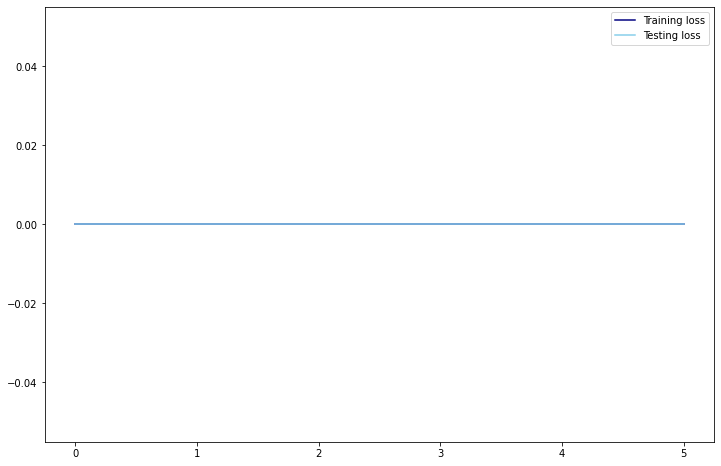

In [25]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

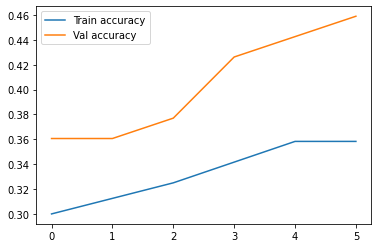

In [26]:
# Visualize loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

#### Save model

In [27]:
model.save('./nn_model')

INFO:tensorflow:Assets written to: ./nn_model/assets


#### Load model

In [176]:
model=tf.keras.models.load_model('./nn_model')

#### Evaluate on test set 

In [177]:
history_test = model.fit(
    X_test,
    y_test,
    validation_data =(X_train, y_train),
    epochs=25,
    batch_size=64,
    callbacks=[early_stop]

)

Epoch 1/25
1/1 [==============================] - 1s 765ms/step - loss: 0.0000e+00 - accuracy: 0.4590 - val_loss: 0.0000e+00 - val_accuracy: 0.3833
Epoch 2/25
1/1 [==============================] - 0s 47ms/step - loss: 0.0000e+00 - accuracy: 0.4754 - val_loss: 0.0000e+00 - val_accuracy: 0.3917
Epoch 3/25
1/1 [==============================] - 0s 54ms/step - loss: 0.0000e+00 - accuracy: 0.4590 - val_loss: 0.0000e+00 - val_accuracy: 0.3958
Epoch 4/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0000e+00 - accuracy: 0.4590 - val_loss: 0.0000e+00 - val_accuracy: 0.4000
Epoch 5/25
1/1 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - accuracy: 0.4590 - val_loss: 0.0000e+00 - val_accuracy: 0.4167
Epoch 6/25
1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 0.4590 - val_loss: 0.0000e+00 - val_accuracy: 0.4208
Epoch 00006: early stopping


#### X_test predictions

In [178]:
y_preds = model.predict(X_test)

#### What do those numbers look like? Let's get rid of that exponential notation and just round the predictions.

In [179]:
y_preds = np.round(y_preds, 0)
y_preds_df = pd.DataFrame(y_preds) 
y_preds_df

,0
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
56,1.0
57,1.0
58,1.0
59,1.0


#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [180]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [181]:
#function to make a confusion matrix in a pandas dataframe

def conmat(y_test, preds, classes):
    conmat = confusion_matrix(y_test, preds)
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

preds = y_preds

conmat(y_test, preds, ['Yes', 'No'])

,Predicted Yes,Predicted No
Actual Yes,19,25
Actual No,8,9


Or just use sklearn's confusion matrix. 

In [182]:
confusion_matrix(y_test, y_preds)

array([[19, 25],
       [ 8,  9]])

#### Evaluate with other sklearn metrics

In [183]:
print(f"Recall score: {np.round(recall_score(y_test, model.predict_classes(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, model.predict_classes(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, model.predict_classes(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, model.predict_classes(X_test),),2)}")

Recall score: 0.46
Accuracy score: 0.46
F1-score score: 0.35
Precision score: 0.26


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### Make a null model

In [184]:
heart_df['target'].value_counts(normalize=True)

0    0.724252
1    0.275748
Name: target, dtype: float64

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [299]:
#instantiate model
model1 = Sequential()

#input layer
n_input = X_train.shape[1]

#dense layers
model1.add(Dense(n_input, 
                input_dim=n_input,
                activation='relu'))
model1.add(Dense(8, 
                activation='relu'))
# model1.add(Dense(2, 
#                 input_dim=n_input,
#                 activation='relu',
#                 ))

#output layer
model1.add(Dense(1, activation='sigmoid'))

In [300]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [301]:
history1 = model1.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=15, batch_size=64, workers = -2)

Epoch 1/15
4/4 [==============================] - 1s 75ms/step - loss: 0.0000e+00 - accuracy: 0.5997 - val_loss: 0.0000e+00 - val_accuracy: 0.6208
Epoch 2/15
4/4 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.6240 - val_loss: 0.0000e+00 - val_accuracy: 0.6250
Epoch 3/15
4/4 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.6532 - val_loss: 0.0000e+00 - val_accuracy: 0.6458
Epoch 4/15
4/4 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.6376 - val_loss: 0.0000e+00 - val_accuracy: 0.6667
Epoch 5/15
4/4 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.6633 - val_loss: 0.0000e+00 - val_accuracy: 0.7000
Epoch 6/15
4/4 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.6827 - val_loss: 0.0000e+00 - val_accuracy: 0.7042
Epoch 7/15
4/4 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.7242 - val_loss: 0.000

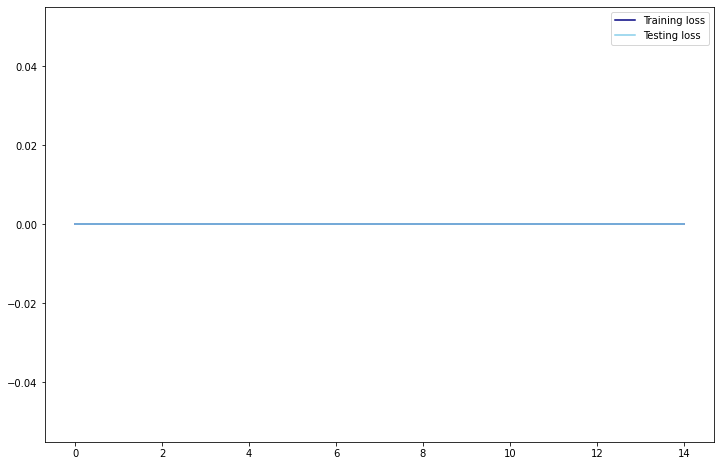

In [302]:
# Visualize the loss
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

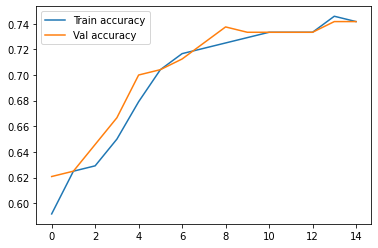

In [303]:
# Visualize accuracy
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']

plt.plot(history1.history['accuracy'], label='Train accuracy')
plt.plot(history1.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [304]:
print(f"Recall score: {np.round(recall_score(y_test, model1.predict_classes(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, model1.predict_classes(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, model1.predict_classes(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, model1.predict_classes(X_test),),2)}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Recall score: 0.72
Accuracy score: 0.72
F1-score score: 0.11
Precision score: 0.5


In [305]:
y_preds_1 = model1.predict(X_test)
y_preds_1 = np.round(y_preds_1, 0)
y_preds_1_df = pd.DataFrame(y_preds_1) 
confusion_matrix(y_test, y_preds_1)

array([[43,  1],
       [16,  1]])

#### Save your best model. 


In [306]:
model1.save('./best_nn_model') 

INFO:tensorflow:Assets written to: ./best_nn_model/assets


#### Compare with other algorithms
Compare your best neural net model to a scikit-learn LogisticRegression model. Also try a GradientBoostingClassifier.

#### Scale/Standardize for Logistic Regression


#### Logistic Regression

In [307]:
lr = LogisticRegression()

In [308]:

lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.8625

In [309]:
lr.score(X_test, y_test)

0.819672131147541

#### Evaluate performance on metrics other than accuracy

In [310]:
print(f"Recall score: {np.round(recall_score(y_test, lr.predict(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, lr.predict(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, lr.predict(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, lr.predict(X_test),),2)}")

Recall score: 0.82
Accuracy score: 0.82
F1-score score: 0.59
Precision score: 0.8


In [311]:
confusion_matrix(y_test, lr.predict(X_test))

array([[42,  2],
       [ 9,  8]])

### GradientBoosting

In [312]:
gbc = GradientBoostingClassifier()

In [313]:
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train)

1.0

In [314]:
gbc.score(X_test, y_test)

0.7868852459016393

#### Evaluate performance on metrics other than accuracy

In [315]:
print(f"Recall score: {np.round(recall_score(y_test, gbc.predict(X_test), average = 'weighted'),2)}")
print(f"Accuracy score: {np.round(accuracy_score(y_test, gbc.predict(X_test),),2)}")
print(f"F1-score score: {np.round(f1_score(y_test, gbc.predict(X_test),),2)}")
print(f"Precision score: {np.round(precision_score(y_test, gbc.predict(X_test),),2)}")

Recall score: 0.79
Accuracy score: 0.79
F1-score score: 0.52
Precision score: 0.7


#### Which evaluation metric(s) are best to use in this problem?

recall or sensitifity is most important here because we want to catch all the people that have the heart problem. Hoever having a decent precision is also nice so we are not falsly predicting a lot of people have it that do not.

#### Which model would you recommend for use? Why?

The Logistical regression was the easiest and most effective. A NN got close and perhaps with more fiddling with it , it could work better. However I ran quite a few models and many of them did a pretty poor job so I'd say those were hit or miss on this dataset. 


#### If you used Google Colab, download your notebook and put it in your Submissions repo. 🎉